# Introduction and Problem Statement:
Along Peachtree there exists the intersections of 10th, 11th, 12th, 13th, and 14th Streets. This simulation will seek to compute the average time cars spent traversing this segment of the road.

# Assumptions:
 - The variations in the shape and size of each intersection is ignored and all intersections are treated equally due to the difficulty in quantifying geographic differences in incline and shape. For example, 10th and Peachtree is shaped more square on flat land whereas 11th and Peachtee is slightly like a rhombus and has a distinct incline going westbound.

 - We assume that throughout the day the intersections themselves do not change geometric shape and that the vehicles that pass through them behave similarly, which means that the traffic signals and the numbers are the determining factors for travel time distributions.

 - We assume our first event is of the first car in the entire roadway. 
 
    
# Details:

 - We assume that for any given left or right turn there is a possiblity that there is an incoming car that would delay that turn and in turn the cars behind the car trying to make that turn would also get delayed. Our principal RNG element is here along with the generation of the interarrival times.
    
 - Once a car enters a queue of a segment, the car travels to the end of the segment and then once it gets to the front of the queue and deqeues from there. If the intersection is 10th or 14th, there are two queues, one for going straight/right or one for going left. Both queues are dependent on their respective lights and cars will only move forward on green. In the case of a car that is at the front of the queue, it will take a right even if its red.
 
 - As specified in the specifications pdf, the traffic is one-way, therefore we will choose to simulate the traffic going northbound from 10th to 14th street through Peachtree.
 
 
    
# Simplifications:

 - Every car travels the same speed regardless of size. This is something we will lilely change in a later iteration of the simulation. We will assume it takes 10 seconds no matter what car it is to traverse any segments between intersections.
 
 - We will also assume one lane for going straight and one lane for left turns.
 
 - The thirteenth intersection doesn't have lights, so we will be skipping that for intersection in this iteration of the model.

 - We are treating yellow and green traffic light phases as the same in our simulation. In a later iteration we could have car speeds slow down during yellows.

In [1]:
from queue import PriorityQueue
from queue import Queue
from __future__ import division
import time
#Graphing and Analysis imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import random
#Reading CSV file imports
import pandas as pd

#Initializing simulation
FEL = PriorityQueue();

#GLT, RLT, GTR, RTR/LT
northSignals10 = [10.6, 2.2, 38.1, 49.3];
northSignals14 = [12.4, 3.6, 37.8, 45.3];
#GTR, RTR/LT
northSignals11 = [44.7, 55.4];
northSignals12 = [64.1, 35.7];
#13th street has no lights!
    
START_TIME = 1163030800;
currentTime = START_TIME;

carTravelTimes = [];
leftTurnChance = 0;
rightTurnChance = 0;
rightTurn = 0;
leftTurn = 0;
#Queue initializations and system states. Segments are named after the preceding intersection
curr10Light = 'green'
curr10LeftLight = 'green';
tenLeftDelay = 0;
tenDelay = 0;

curr11Light = 'green'
elevenDelay = 0;

curr12Light = 'green'
twelveDelay = 0;

curr14Light = 'green'
curr14LeftLight = 'green';
fourteenDelay = 0;
fourteenLeftDelay = 0;

In [2]:
### Populate our event list
def getHistoricalEvents():
    df = pd.read_csv('./data/trajectories.csv', usecols=['Vehicle_ID', 'Frame_ID','Tot_Frames', 'Epoch_ms', 'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'Veh_Len', 'Veh_Wid', 'Veh_Class', 'Veh_Velocity', 'Vehicle_Acc', 'Lane_ID', 'Org_Zone', 'Dest_Zone', 'Intersection', 'Section', 'Direction', 'Movement', 'Preceding_Veh', 'Following_Veh', 'Spacing', 'Headway']);
    counter = 0;
    global events
    global leftTurnChance
    global rightTurnChance
    events = {}

    for i, row in enumerate(df.values):
        events[counter] = {}
        counter = counter + 1;

    counter = 0;
    for i, row in enumerate(df.values):
        events[counter] = {
            'Vehicle_ID': row[0],
            'Frame_ID': row[1],
            'Tot_Frames': row[2],
            'Epoch_ms': row[3],
            'Local_X': row[4],
            'Local_Y': row[5],
            'Global_X': row[6],
            'Global_Y': row[7],
            'Veh_Len': row[8],
            'Veh_Wid': row[9],
            'Veh_Class': row[10],
            'Veh_Velocity': row[11],
            'Vehicle_Acc': row[12],
            'Lane_ID': row[13],
            'Org_Zone': row[14],
            'Dest_Zone': row[15],
            'Intersection': row[16],
            'Section': row[17],
            'Direction': row[18],
            'Movement': row[19],
            'Preceding_Veh': row[20],
            'Following_Veh': row[21],
            'Spacing': row[22],
            'Headway': row[23]
        }
        counter = counter + 1
    FEL.put((currentTime + northSignals10[3]*100, ['NorthSignals10', 'red']))      #Traffic lights shceduled
    FEL.put((currentTime + northSignals11[1]*100, ['NorthSignals11', 'red']))
    FEL.put((currentTime + northSignals12[1]*100, ['NorthSignals12', 'red']))
    FEL.put((currentTime + northSignals14[3]*100, ['NorthSignals14', 'red']))
    FEL.put((currentTime + northSignals10[1]*100, ['NorthSignalsLeft10', 'red']))    #Traffic left lights scheduled
    FEL.put((currentTime + northSignals14[3]*100, ['NorthSignalsLeft14', 'red']))  
    arrivalTime = getInterArrivalTime()
    leftTurnChance = getLeftTurnChance();
    rightTurnChance = getRightTurnChance();
    FEL.put((arrivalTime, ['NinthSegment', leftTurnChance, rightTurnChance, arrivalTime]))  #First Car event that is scheduled

#Randomly generated interarrival time
def getInterArrivalTime():
    #Interarrival times
    interArrivalTimes = [0]
    for n in range(len(events.keys())):
        interArrivalTimes.append(0)
    for z in range(len(events.keys())):        
        interArrivalTimes[z] = events[z]['Epoch_ms'] - START_TIME;
    i = random.randint(0, len(interArrivalTimes))
    if (interArrivalTimes[i] < currentTime):
        return abs(interArrivalTimes[i] - currentTime) + interArrivalTimes[i] + 500
    return interArrivalTimes[i]; 

#Calculate chance for left turn
def getRightTurnChance():
    #Left turns
    intersectionCounter = 0;
    leftTurnCounter = 0;
    for z in range(len(events.keys())):
        if (events[z]['Intersection'] != 0):
            intersectionCounter = intersectionCounter + 1
            if (events[z]['Movement'] == 2):
                leftTurnCounter = leftTurnCounter + 1
    leftTurnChance = leftTurnCounter / intersectionCounter;
    return leftTurnChance
        
#Calculate chance for right turn
def getLeftTurnChance():
    #Left turns
    intersectionCounter = 0;
    rightTurnCounter = 0;
    for z in range(len(events.keys())):
        if (events[z]['Intersection'] != 0):
            intersectionCounter = intersectionCounter + 1
            if (events[z]['Movement'] == 3):
                rightTurnCounter = rightTurnCounter + 1
    rightTurnChance = rightTurnCounter / intersectionCounter;
    return rightTurnChance;
        
    

In [3]:
#Execute the event and schedule the next events
def executeEvent(event):
    #Read type of event and execute that event
    if (event[1][0] == 'NorthSignals10'):
        switchTenthLights(event)
    elif (event[1][0] == 'NorthSignalsLeft10'):
        switchTenthLeftLights(event)    
    elif (event[1][0] == 'NorthSignals11'):
        switchEleventhLights(event)
    elif (event[1][0] == 'NorthSignals12'):
        switchTwelfthLights(event)
    elif (event[1][0] == 'NorthSignals14'):
        switchFourteenthLights(event)
    elif (event[1][0] == 'NorthSignalsLeft14'):
        switchFourteenthLeftLights(event)
    elif (event[1][0] == 'NinthSegment'):
        ninthSegment(event)
    elif (event[1][0] == 'TenthIntersection'):
        tenthIntersection(event)
    elif (event[1][0] == 'TenthSegment'):
        tenthSegment(event)
    elif (event[1][0] == 'EleventhIntersection'):
        eleventhIntersection(event)    
    elif (event[1][0] == 'EleventhSegment'):
        eleventhSegment(event)
    elif (event[1][0] == 'TwelfthIntersection'):
        twelfthIntersection(event);
    elif (event[1][0] == 'TwelfthSegment'):
        twelfthSegment(event)
    elif (event[1][0] == 'FourteenthIntersection'):
        fourteenthIntersection(event);
    elif (event[1][0] == 'FourteenthSegment'):
        fourteenthSegment(event)
    #New Event
    if (currentTime % 2000 == 0):
        arrivalTime = getInterArrivalTime()
        FEL.put((arrivalTime, ['NinthSegment', leftTurnChance, rightTurnChance, arrivalTime]))

In [4]:
#Event - Entering segment before 10th intersection
def ninthSegment(event):
    turnResult = checkLeftRightTurn(event);
    if (turnResult == 1):
        FEL.put((event[0] + 100, ['TenthIntersection', event[1][1], event[1][2], event[1][3], 1]))
    elif (turnResult == 2):
        FEL.put((event[0] + 100, ['TenthIntersection', event[1][1], event[1][2], event[1][3], 2]))
    else:
        FEL.put((event[0]+ 100, ['TenthIntersection', event[1][1], event[1][2], event[1][3], 0]))
        
#Event - Entering 10th intersection
def tenthIntersection(event):
    global tenDelay;
    global tenLeftDelay;
    global leftTurn;
    global rightTurn;
    if (event[1][4] == 2):
        if (curr10LeftLight == 'green'):
            leftTurn = leftTurn + 1
            carTravelTimes.append(event[0] - event[1][3])
        else:
            FEL.put((event[0] + 200, ['TenthIntersection', event[1][1], event[1][2], event[1][3], 2]))
            tenLeftDelay = tenLeftDelay + 200;
    elif (event[1][4] == 1):
        rightTurn = rightTurn + 1;
        carTravelTimes.append(event[0] - event[1][3])
    else:
        if (curr10Light == 'green'):
            FEL.put((event[0] + 100, ['TenthSegment', event[1][1], event[1][2], event[1][3], 0]))
        else:
            FEL.put((event[0] + 200, ['TenthIntersection', event[1][1], event[1][2], event[1][3], 0]))
            tenDelay = tenDelay + 200  
    
#Event - Entering 10th Segment
def tenthSegment(event):
    turnResult = checkLeftRightTurn(event);
    if (turnResult == 1):
        FEL.put((event[0] + 100, ['EleventhIntersection', event[1][1], event[1][2], event[1][3], 1]))
    elif (turnResult == 2):
        FEL.put((event[0] + 100, ['EleventhIntersection', event[1][1], event[1][2], event[1][3], 2]))
    else:
        FEL.put((event[0]+ 100, ['EleventhIntersection', event[1][1], event[1][2], event[1][3], 0]))
        
#Event - Entering 11th intersection
def eleventhIntersection(event):
    global elevenDelay;
    global leftTurn;
    global rightTurn;
    if (event[1][4] == 1):
        rightTurn = rightTurn + 1;
        carTravelTimes.append(event[0] - event[1][3])
    else:
        if (curr10Light == 'green'):
            FEL.put((event[0] + 100, ['EleventhSegment', event[1][1], event[1][2], event[1][3], 0]))
        else:
            FEL.put((event[0] + 200, ['EleventhIntersection', event[1][1], event[1][2], event[1][3], 0]))
            elevenDelay = elevenDelay + 200    

#Event - Entering 11th segment
def eleventhSegment(event):
    turnResult = checkLeftRightTurn(event);
    if (turnResult == 1):
        FEL.put((event[0] + 100, ['TwelfthIntersection', event[1][1], event[1][2], event[1][3], 1]))
    elif (turnResult == 2):
        FEL.put((event[0] + 100, ['TwelfthIntersection', event[1][1], event[1][2], event[1][3], 2]))
    else:
        FEL.put((event[0]+ 100, ['TwelfthIntersection', event[1][1], event[1][2], event[1][3], 0]))

#Event - Entering 12th intersection
def twelfthIntersection(event):
    global twelveDelay;
    global leftTurn;
    global rightTurn;
    if (event[1][4] == 1):
        rightTurn = rightTurn + 1;
        carTravelTimes.append(event[0] - event[1][3])
    else:
        if (curr12Light == 'green'):
            FEL.put((event[0] + 100, ['TwelfthSegment', event[1][1], event[1][2], event[1][3], 0]))
        else:
            FEL.put((event[0] + 200, ['TwelfthIntersection', event[1][1], event[1][2], event[1][3], 0]))
            twelveDelay = twelveDelay + 200    

#Event - Entering 12th segment
def twelfthSegment(event):
    turnResult = checkLeftRightTurn(event);
    if (turnResult == 1):
        FEL.put((event[0] + 100, ['FourteenthIntersection', event[1][1], event[1][2], event[1][3], 1]))
    elif (turnResult == 2):
        FEL.put((event[0] + 100, ['FourteenthIntersection', event[1][1], event[1][2], event[1][3], 2]))
    else:
        FEL.put((event[0]+ 100, ['FourteenthIntersection', event[1][1], event[1][2], event[1][3], 0]))

#Event - Entering 14th intersection
def fourteenthIntersection(event):
    global fourteenDelay;
    global fourteenLeftDelay;
    global leftTurn;
    global rightTurn;
    if (event[1][4] == 2):
        if (curr14LeftLight == 'green'):
            leftTurn = leftTurn + 1
            carTravelTimes.append(event[0] - event[1][3])
        else:
            FEL.put((event[0] + 200, ['FourteenthIntersection', event[1][1], event[1][2], event[1][3], 2]))
            tenLeftDelay = tenLeftDelay + 200;
    elif (event[1][4] == 1):
        rightTurn = rightTurn + 1;
        carTravelTimes.append(event[0] - event[1][3])
    else:
        if (curr14Light == 'green'):
            FEL.put((event[0] + 100, ['FourteenthSegment', event[1][1], event[1][2], event[1][3], 0]))
        else:
            FEL.put((event[0] + 200, ['FourteenthIntersection', event[1][1], event[1][2], event[1][3], 0]))
            fourteenDelay = fourteenDelay + 200

#Event - Entering 14th segment
def fourteenthSegment(event):
    carTravelTimes.append(event[0] - event[1][3])
            
#Determine if car is going to take a left or right at a particular intersection
def checkLeftRightTurn(event):
    u = random.randint(100, 1000)/1000;
    if (u < rightTurnChance):
        return 1;
    u = random.randint(100, 1000)/1000;
    if (u < leftTurnChance):
        return 2;
    return 0;

In [5]:
#Event - Switch 10th Street Lights
def switchTenthLights(event):
    if (event[1][1] == 'red'):
        curr10Light = 'red';
        FEL.put((currentTime + northSignals10[2]*100, ['NorthSignals10', 'green']))      #Traffic lights shceduled
    else:
        curr10Light = 'green';
        FEL.put((currentTime + northSignals10[3]*100, ['NorthSignals10', 'red']))      #Traffic lights shceduled
        
#Event - Switch 10th Street Left Turn Lights
def switchTenthLeftLights(event):
    if (event[1][1] == 'red'):
        curr10LeftLight = 'red';
        FEL.put((currentTime + northSignals10[0]*100, ['NorthSignalsLeft10', 'green']))      #Traffic lights shceduled
    else:
        curr10LeftLight = 'green';
        FEL.put((currentTime + northSignals10[1]*100, ['NorthSignalsLeft10', 'red']))      #Traffic lights shceduled

#Event - Switch 11t Street Lights
def switchEleventhLights(event):
    if (event[1][1] == 'red'):
        curr11Light = 'red';
        FEL.put((currentTime + northSignals11[0]*100, ['NorthSignals11', 'green']))      #Traffic lights shceduled
    else:
        curr11Light = 'green';
        FEL.put((currentTime + northSignals11[1]*100, ['NorthSignals11', 'red']))      #Traffic lights shceduled

#Event - Switch 12th Street Lights
def switchTwelfthLights(event):
    if (event[1][1] == 'red'):
        curr12Light = 'red';
        FEL.put((currentTime + northSignals12[0]*100, ['NorthSignals12', 'green']))      #Traffic lights shceduled
    else:
        curr12Light = 'green';
        FEL.put((currentTime + northSignals12[1]*100, ['NorthSignals12', 'red']))      #Traffic lights shceduled

#Event - Switch 12th Street Lights
def switchFourteenthLights(event):
    if (event[1][1] == 'red'):
        curr14Light = 'red';
        FEL.put((currentTime + northSignals14[2]*100, ['NorthSignals14', 'green']))      #Traffic lights shceduled
    else:
        curr14Light = 'green';
        FEL.put((currentTime + northSignals14[3]*100, ['NorthSignals14', 'red']))      #Traffic lights shceduled

        #Event - Switch 12th Street Left Turn Lights
def switchFourteenthLeftLights(event):
    if (event[1][1] == 'red'):
        curr14LeftLight = 'red';
        FEL.put((currentTime + northSignals14[0]*100, ['NorthSignalsLeft14', 'green']))      #Traffic lights shceduled
    else:
        curr14LeftLight = 'green';
        FEL.put((currentTime + northSignals14[1]*100, ['NorthSignalsLeft14', 'red']))      #Traffic lights shceduled



In [6]:
#Graphng average travel time from 10th to 14th street
def graphCarTravelTimes():
    #Get average car time in simulation in array format
    carTravelTimes.sort()
    fit = stats.norm.pdf(carTravelTimes, np.mean(carTravelTimes), np.std(carTravelTimes))  #this is a fitting indeed
    plt.plot(carTravelTimes,fit,'-o')
    plt.hist(carTravelTimes,normed=True)      #use this to draw histogram of your data
    plt.xlabel('Time in deciseconds')
    plt.ylabel('Probability Density')
    plt.title("Time spent traveling down Peachtree Street")
    plt.show()                   #use may also need add this 
   

In [7]:
#Start Program
def main():
    #Initialize event list with first arrival
    getHistoricalEvents();
    #Start timer
    t0 = time.clock();
    wt0 = time.time();
    #Run Simulation
    runSimulation();
    #End Timer
    t1 = time.clock();
    wt1 = time.time();
    #print(t1 - t0)
    graphCarTravelTimes();
    

In [8]:
#Our simulation engine
def runSimulation():
    global FEL;
    global currentTime;
    global START_TIME
    print('Events being processed')
    while currentTime < START_TIME + 100000:
        next_item = FEL.get();                             #Get next event
        currentTime = currentTime + 100                   #Advance simulation time
        #if (next_item[1][0] != 'NorthSignalsLeft14' and next_item[1][0] != 'NorthSignalsLeft10'):
            #print(next_item)
        executeEvent(next_item);                      #Update state variables and counters and generate future events
        


Events being processed


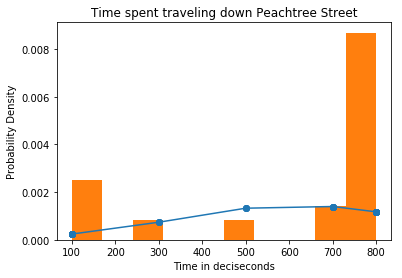

In [9]:
main()